# 5. How to Log and Visualize Simulations

Here we explain how to take a log of simulation results and how to visualize it. 

In [1]:
%matplotlib inline
import math
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

## 5.1. Logging Simulations with Observers

E-Cell4 provides special classes for logging, named `Observer`. `Observer` class is given when you call the `run` function of `Simulator`.

In [2]:
def create_simulator(f=gillespie.Factory()):
    m = NetworkModel()
    A, B, C = Species('A', 0.005, 1), Species('B', 0.005, 1), Species('C', 0.005, 1)
    m.add_species_attribute(A)
    m.add_species_attribute(B)
    m.add_species_attribute(C)
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.simulator(w)
    sim.initialize()
    return sim

One of most popular `Observer` is `FixedIntervalNumberObserver`, which logs the number of molecules with the given time interval. `FixedIntervalNumberObserver` requires an interval and a list of serials of `Species` for logging.

In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`data` function of `FixedIntervalNumberObserver` returns the data logged.

In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 4.0, 4.0, 56.0], [0.2, 4.0, 4.0, 56.0], [0.30000000000000004, 4.0, 4.0, 56.0], [0.4, 5.0, 5.0, 55.0], [0.5, 6.0, 6.0, 54.0], [0.6000000000000001, 8.0, 8.0, 52.0], [0.7000000000000001, 9.0, 9.0, 51.0], [0.8, 10.0, 10.0, 50.0], [0.9, 10.0, 10.0, 50.0], [1.0, 13.0, 13.0, 47.0]]


`targets()` returns a list of `Species`, which you specified as an argument of the constructor.

In [5]:
print([sp.serial() for sp in obs1.targets()])

['A', 'B', 'C']


`NumberObserver` logs the number of molecules after every steps when a reaction occurs. This observer is useful to log all reactions, but not available for `ode`.

In [6]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.02260889225454991, 1.0, 1.0, 59.0], [0.02969136490582789, 2.0, 2.0, 58.0], [0.03733168118750063, 3.0, 3.0, 57.0], [0.07073952925465954, 4.0, 4.0, 56.0], [0.130436288313097, 5.0, 5.0, 55.0], [0.24790263332591864, 6.0, 6.0, 54.0], [0.3617656247136509, 7.0, 7.0, 53.0], [0.3766811515853057, 8.0, 8.0, 52.0], [0.49416987912466614, 9.0, 9.0, 51.0], [0.5432711094028326, 10.0, 10.0, 50.0], [0.71741755480935, 11.0, 11.0, 49.0], [0.7488858466586021, 12.0, 12.0, 48.0], [0.7793994960089041, 11.0, 11.0, 49.0], [0.8704209616639759, 12.0, 12.0, 48.0], [0.9744942945378776, 13.0, 13.0, 47.0], [0.9795754005617485, 14.0, 14.0, 46.0], [1.0, 14.0, 14.0, 46.0]]


`TimingNumberObserver` allows you to give the times for logging as an argument of its constructor.

In [7]:
obs1 = TimingNumberObserver([0.0, 0.1, 0.2, 0.5, 1.0], ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 4.0, 4.0, 56.0], [0.2, 4.0, 4.0, 56.0], [0.5, 8.0, 8.0, 52.0], [1.0, 14.0, 14.0, 46.0]]


`run` function accepts multile `Observer`s at once.

In [8]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.02260889225454991, 59.0], [0.02969136490582789, 58.0], [0.03733168118750063, 57.0], [0.07073952925465954, 56.0], [0.3144142385275013, 55.0], [0.44722512356903055, 54.0], [0.5302331233889856, 53.0], [0.5597228247745124, 52.0], [0.6798940199866744, 51.0], [0.7165839475888072, 50.0], [0.9254471286586852, 49.0], [0.9492284464115648, 48.0], [0.9602086431679366, 47.0], [1.0, 47.0]]
[[0.0, 0.0, 0.0], [0.1, 4.0, 4.0], [0.2, 4.0, 4.0], [0.30000000000000004, 4.0, 4.0], [0.4, 5.0, 5.0], [0.5, 6.0, 6.0], [0.6000000000000001, 8.0, 8.0], [0.7000000000000001, 9.0, 9.0], [0.8, 10.0, 10.0], [0.9, 10.0, 10.0], [1.0, 13.0, 13.0]]


`FixedIntervalHDF5Observedr` logs the whole data in a `World` to an output file with the fixed interval. Its second argument is a prefix for output filenames. `filename()` returns the name of a file scheduled to be saved next. At most one format string like `%02d` is allowed to use a step count in the file name. When you do not use the format string, it overwrites the latest data to the file.

In [9]:
obs1 = FixedIntervalHDF5Observer(0.2, 'test%02d.h5')
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1) # Now you have steped 5 (1.0/0.2) times
print(obs1.filename())

test00.h5
test06.h5


In [10]:
w = load_world('test05.h5')
print(w.t(), w.num_molecules(Species('C')))

1.0 47


The usage of `FixedIntervalCSVObserver` is almost same with that of `FixedIntervalHDF5Observer`. It saves positions (x, y, z) of particles with the radius (r) and serial number of `Species` (sid) to a CSV file.

In [11]:
obs1 = FixedIntervalCSVObserver(0.2, "test%02d.csv")
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

test00.csv
test06.csv


Here is the first 10 lines in the output CSV file.

In [12]:
print(''.join(open("test05.csv").readlines()[: 10]))

x,y,z,r,sid
0.605209,0.35387,0.426092,0,0
0.7105,0.699568,0.662126,0,0
0.362397,0.863948,0.0881481,0,0
0.663826,0.79369,0.763512,0,0
0.669228,0.605234,0.23582,0,0
0.597962,0.472582,0.458323,0,0
0.153892,0.781189,0.738202,0,0
0.972426,0.643748,0.545462,0,0
0.793828,0.519622,0.299548,0,0



For particle simulations, E-Cell4 also provides `Observer` to trace a trajectory of a molecule, named `FixedIntervalTrajectoryObserver`. When no `ParticleID` is specified, it logs all the trajectories. Once some `ParticleID` is lost for the reaction during a simulation, it just stop to trace the particle any more.

In [13]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [14]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.8573214099741124, 0.964174949546675, 0.19), (0.8001666493091716, 0.8140638795573724, 0.24), (0.5470527092215764, 0.8169506309033205, 0.525), (0.6450322989329036, 0.626425042070744, 0.385), (0.7021870595978444, 0.35507041555161983, 0.5650000000000001), (0.68585712797929, 0.4763139720814413, 0.765), (0.8001666493091716, 0.6235382907247958, 0.65), (0.6205374015050719, 0.48497422611928565, 0.5700000000000001), (0.5470527092215764, 0.5658032638058333, 0.31), (0.28577380332470415, 0.7736493607140986, 0.27), (0.27760883751542687, 0.9266471820493494, 0.225)]


Generally, `World` assumes a periodic boundary for each plane. To avoid the big jump of a particle at the edge due to the boundary condition, `FixedIntervalTrajectoryObserver` tries to keep the shift of positions. Thus, the positions stored in the `Observer` are not necessarily limited in the cuboid given for the `World`. To track the diffusion over the boundary condition accurately, the step interval for logging must be small enough. Of course, you can disable this option. See `help(FixedIntervalTrajectoryObserver)`.

## 5.2. Visualization of Data Logged

In this section, we explain the visualization tools for data logged by `Observer`.

Firstly, for time course data, `viz.plot_number_observer` plots the data provided by `NumberObserver`, `FixedIntervalNumberObserver` and `TimingNumberObserver`. For the detailed usage of `viz.plot_number_observer`, see `help(viz.plot_number_observer)`.

In [15]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

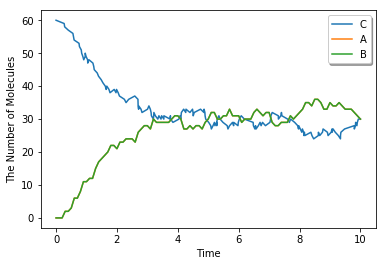

In [16]:
viz.plot_number_observer(obs1, obs2)

You can set the style for plotting, and even add an arbitrary function to plot.

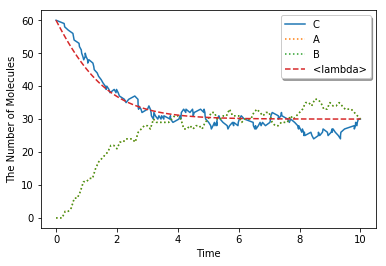

In [17]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * (1 + 2 * math.exp(-0.9 * t)) / (2 + math.exp(-0.9 * t)), '--')

Plotting in the phase plane is also available by specifing the x-axis and y-axis.

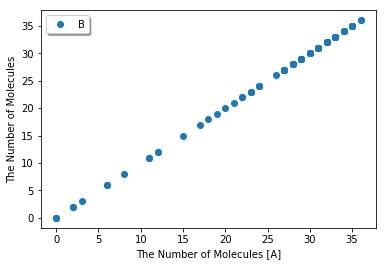

In [18]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

For spatial simulations, to visualize the state of `World`, `viz.plot_world` is available. This function plots the points of particles in three-dimensional volume in the interactive way. You can save the image by clicking a right button on the drawing region.

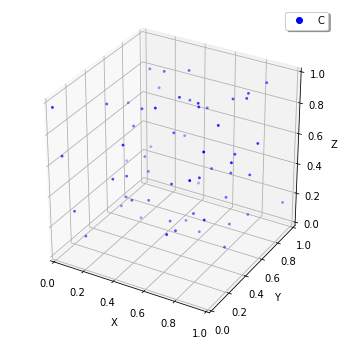

In [19]:
sim = create_simulator(spatiocyte.Factory(0.005))
# viz.plot_world(sim.world())
viz.plot_world(sim.world(), interactive=False)

You can also make a movie from a series of HDF5 files, given as a `FixedIntervalHDF5Observer`. NOTE: `viz.plot_movie` requires an extra library, `ffmpeg`, when `interactive=False`.

In [20]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie(obs1)

Finally, corresponding to `FixedIntervalTrajectoryObserver`, `viz.plot_trajectory` provides a visualization of particle trajectories.

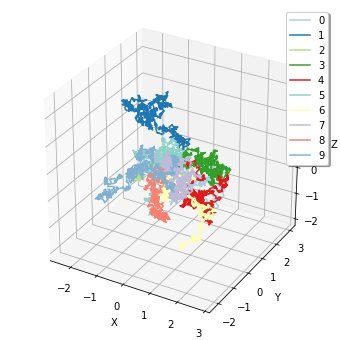

In [21]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
# viz.plot_trajectory(obs1)
viz.plot_trajectory(obs1, interactive=False)